## Environment and Data

### Software Environment

We're going to start by importing the software packages we need. Python stdlib packages:


In [1]:
from pathlib import Path

PyData packages:


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from joblib import Parallel, delayed

LensKit packages:


In [4]:
from lenskit import topn

Local code:


In [5]:
from lkdemo.plotutils import *
from eval_tables import EvalTable
from IPython.display import HTML

Set up progress and logging output:


In [6]:
from tqdm.auto import tqdm
import logging
import lenskit.util

_log = logging.getLogger('notebook')
lenskit.util.log_to_notebook()
tqdm.pandas()

[   INFO] lenskit.util.log notebook logging configured


Where do we want output?


In [7]:
fig_dir = init_figs('Repitition')
print(fig_dir)

using figure dir figures/Repitition
figures/Repitition


### Loading Data

Now let's load the MovieLens data and recommendation outputs.  We can't load all the data into memory at once,
but we *can* compute the statistics!


In [8]:
run_dir = Path('runs')
scores = {
    f.name.split('-')[1]: pd.read_parquet(f) for f in run_dir.glob('*-scores.parquet')
}
scores = pd.concat(scores, names=['algo'])
scores.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 225000 entries, ('Pop', '15', 3) to ('IALS', '29', 6040)
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   nrecs       225000 non-null  int64  
 1   rbp         224846 non-null  float64
 2   ndcg        225000 non-null  float64
 3   recip_rank  225000 non-null  float64
 4   hit         225000 non-null  float32
 5   hit10       225000 non-null  float32
 6   hit20       225000 non-null  float32
 7   ntruth      225000 non-null  int64  
dtypes: float32(3), float64(3), int64(2)
memory usage: 12.2+ MB


In [9]:
scores.reset_index(inplace=True)
scores.algo = scores.algo.astype('category').cat.rename_categories({'III': 'IKNN'})
scores.head()

,algo,run,user,nrecs,rbp,ndcg,recip_rank,hit,hit10,hit20,ntruth
0,Pop,15,3,1000,8.240357e-02,0.255276,0.250000,1.0,1.0,1.0,5
1,Pop,15,6,1000,3.094850e-04,0.124150,0.034483,1.0,0.0,0.0,5
2,Pop,15,11,1000,3.568120e-06,0.173920,0.020408,1.0,0.0,0.0,5
3,Pop,15,13,1000,8.711229e-06,0.156549,0.022222,1.0,0.0,0.0,5
4,Pop,15,16,1000,3.794275e-10,0.157499,0.011111,1.0,0.0,0.0,5


And load user data:


In [10]:
ml_dir = Path('data/ml-1m/')
users = pd.read_table(ml_dir / 'users.dat', sep='::', names=['user', 'gender', 'age', 'occ', 'zip'], engine='python')
users.set_index('user', inplace=True)
users.head()

,gender,age,occ,zip
user,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


## Basic Distribution

What is the distribution of performance over runs?


In [11]:
run_scores = scores.fillna(0).groupby(['algo', 'run']).mean()
run_scores.reset_index(inplace=True)

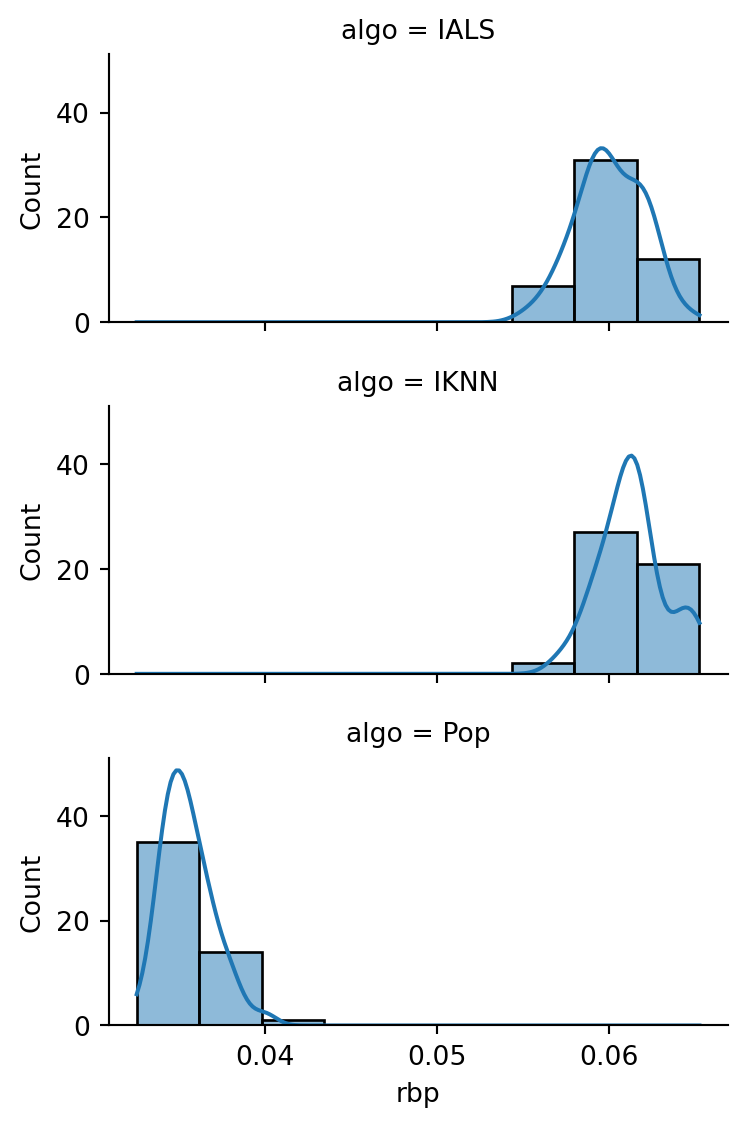

In [12]:
sns.displot(run_scores, x='rbp', row='algo', kde=True, aspect=2, height=2)
plt.show()

/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 3.5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/Repitition/repetition-dist.png


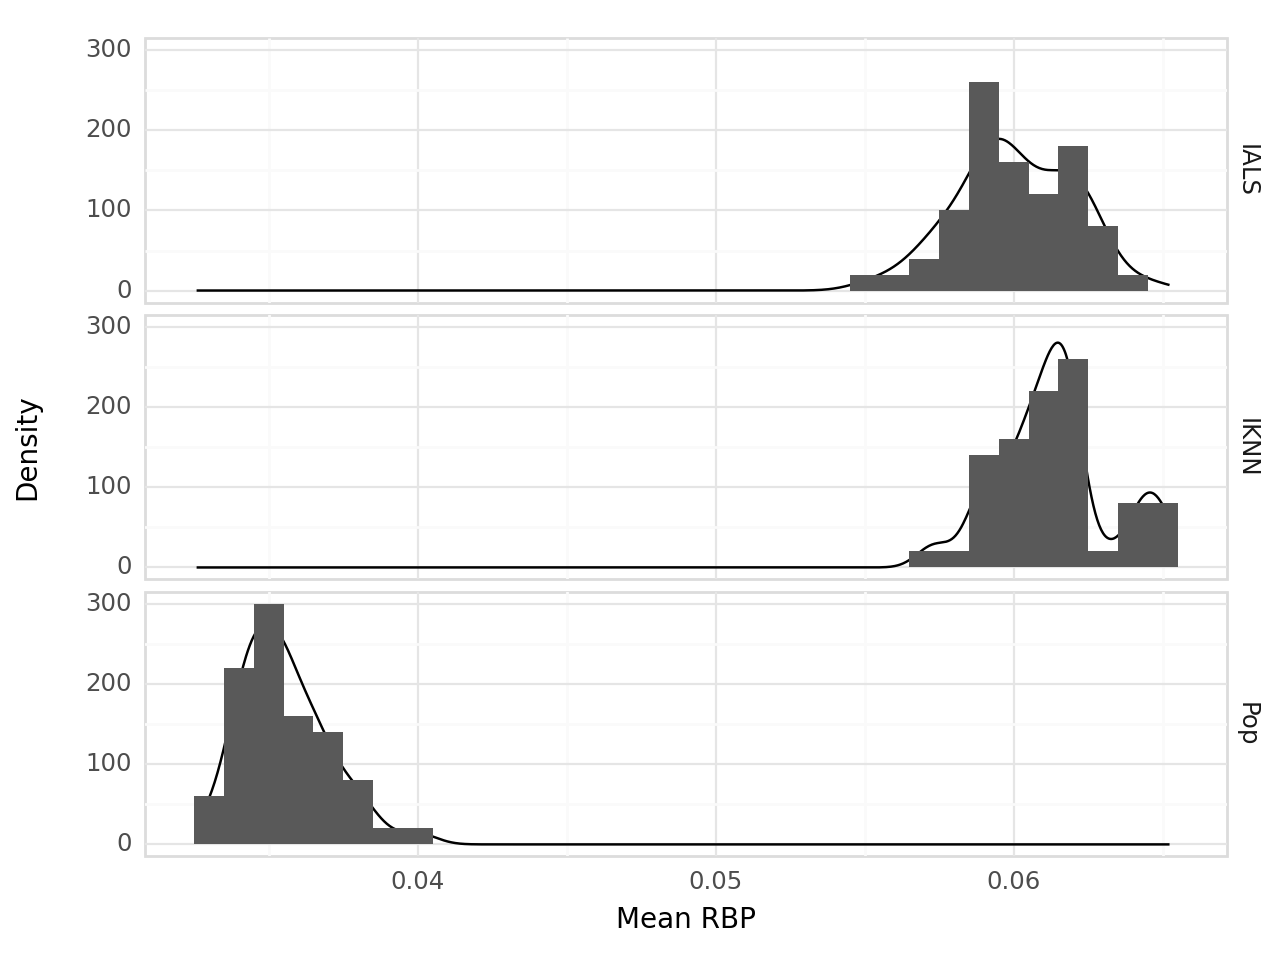

<Figure Size: (640 x 480)>

In [13]:
make_plot(
    run_scores,
    pn.aes(x='rbp', y=pn.after_stat('density')),
    pn.stat_density(),
    pn.geom_histogram(binwidth=0.001),
    pn.facet_grid('algo ~'),
    pn.xlab('Mean RBP'),
    pn.ylab('Density'),
    width=4.5,
    height=3.5,
    file='repetition-dist.png',
)

We can see that there is variance in the scores, and it is hit and miss whether IKNN or IALS is better.


In [14]:
run_scores.groupby('algo')['rbp'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
algo,,,,
IALS,0.060053,0.059933,0.055311,0.064452
IKNN,0.061295,0.061267,0.057128,0.065225
Pop,0.035526,0.035322,0.032583,0.040031


What is the improvement of IALS over IKNN?


In [15]:
run_ndcg = run_scores.pivot(index='run', columns='algo', values='rbp')
run_ndcg['IALS-IKNN'] = run_ndcg['IALS'] - run_ndcg['IKNN']

In [16]:
run_ndcg.describe()

algo,IALS,IKNN,Pop,IALS-IKNN
count,50.000000,50.000000,50.000000,50.000000
mean,0.060053,0.061295,0.035526,-0.001242
std,0.001943,0.001891,0.001479,0.002535
min,0.055311,0.057128,0.032583,-0.006230
25%,0.058833,0.060193,0.034398,-0.003189
50%,0.059933,0.061267,0.035322,-0.001410
75%,0.061536,0.061928,0.036466,0.000650
max,0.064452,0.065225,0.040031,0.004262


Let's look at the distribution:


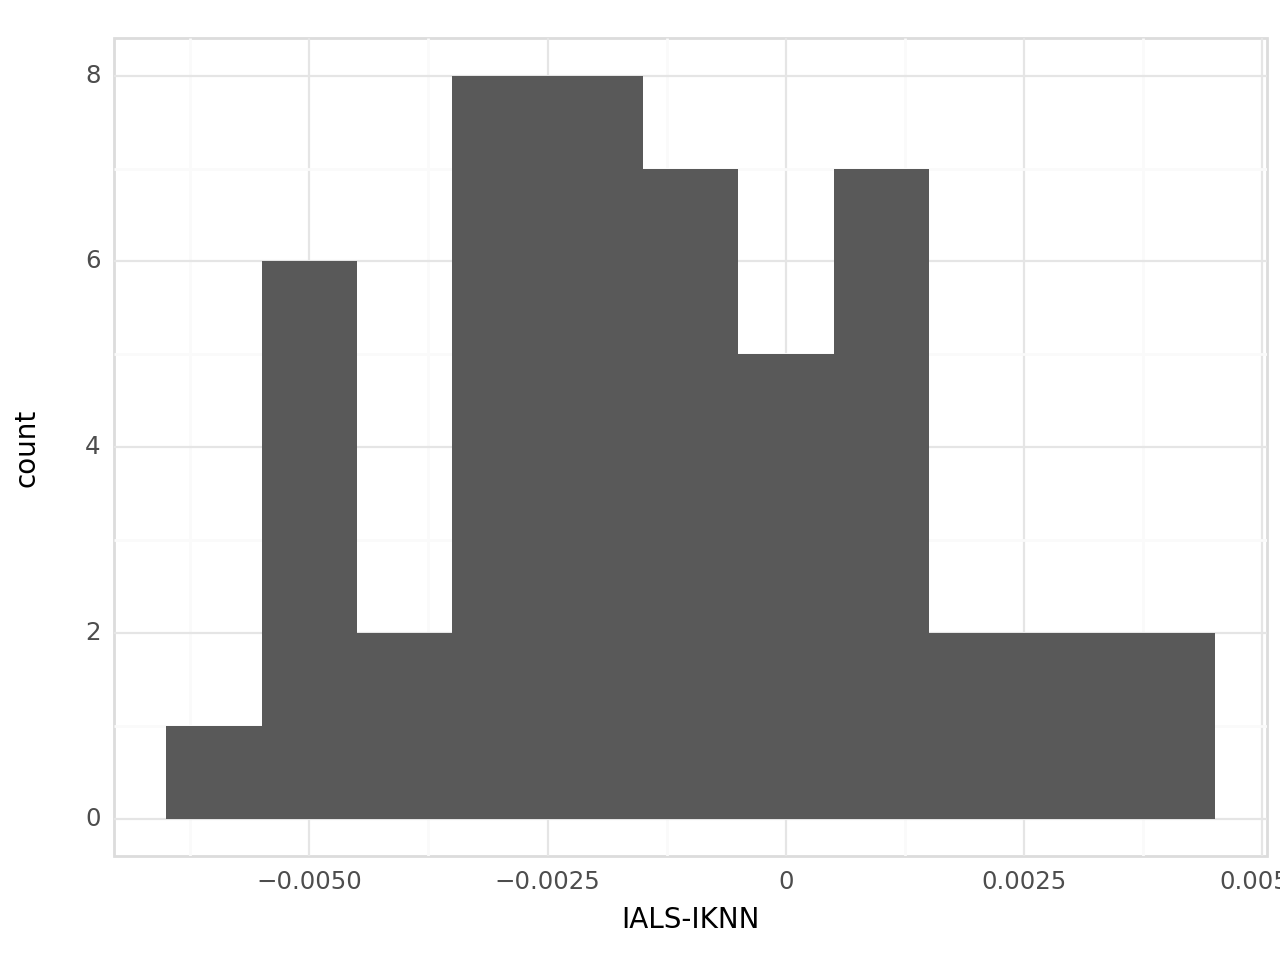

<Figure Size: (640 x 480)>

In [17]:
make_plot(
    run_ndcg,
    pn.aes(x='IALS-IKNN'),
    pn.geom_histogram(binwidth=0.001),
)

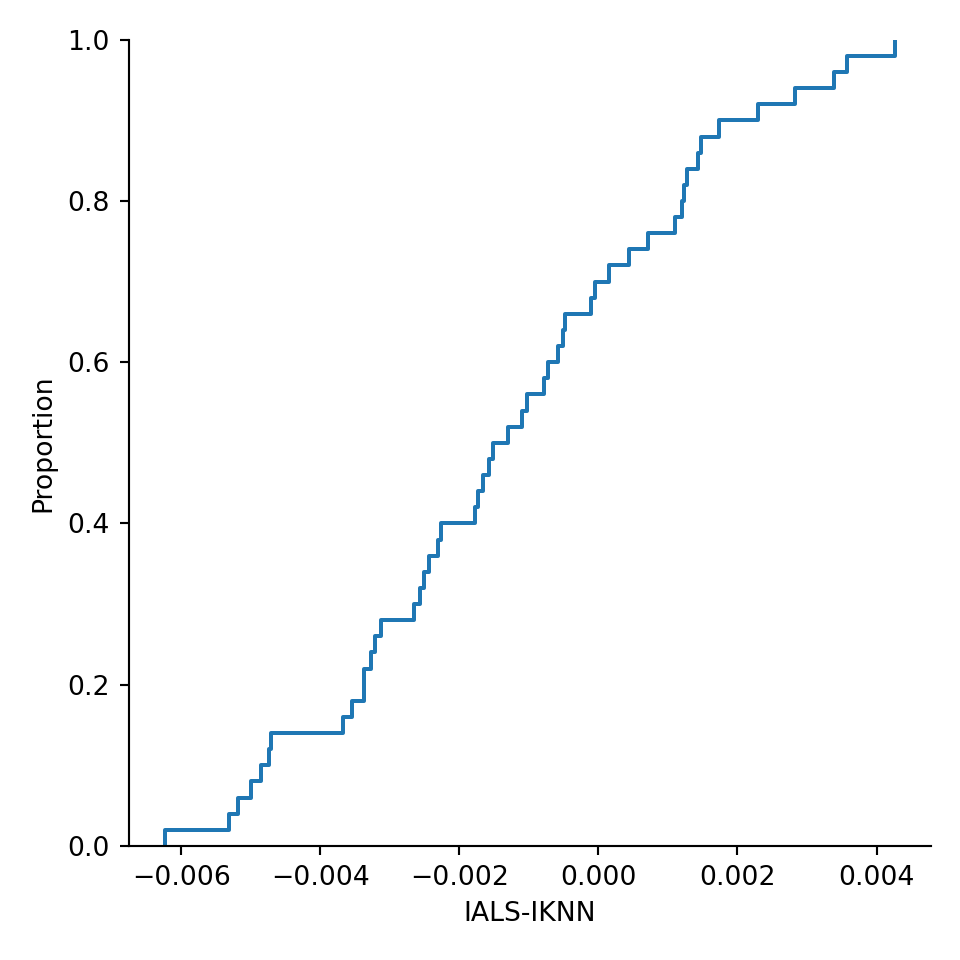

In [18]:
sns.displot(run_ndcg['IALS-IKNN'], kind='ecdf')

## Stability of Gender Improvement

Is the improvement by user gender stable?


In [19]:
aug_scores = scores.join(users['gender'], on='user')
ag_mean = aug_scores.groupby(['run', 'algo', 'gender'])['rbp'].agg(['mean', 'median'])
ag_mean.reset_index(inplace=True)
ag_mean

,run,algo,gender,mean,median
0,0,IALS,F,0.057956,0.020666
1,0,IALS,M,0.064507,0.026844
2,0,IKNN,F,0.050089,0.007037
3,0,IKNN,M,0.064330,0.017180
4,0,Pop,F,0.028770,0.000101
...,...,...,...,...,...
295,9,IALS,M,0.061661,0.025082
296,9,IKNN,F,0.051753,0.007641
297,9,IKNN,M,0.065362,0.021475
298,9,Pop,F,0.030132,0.000172


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 3.5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/Repitition/repetition-gender-dist.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


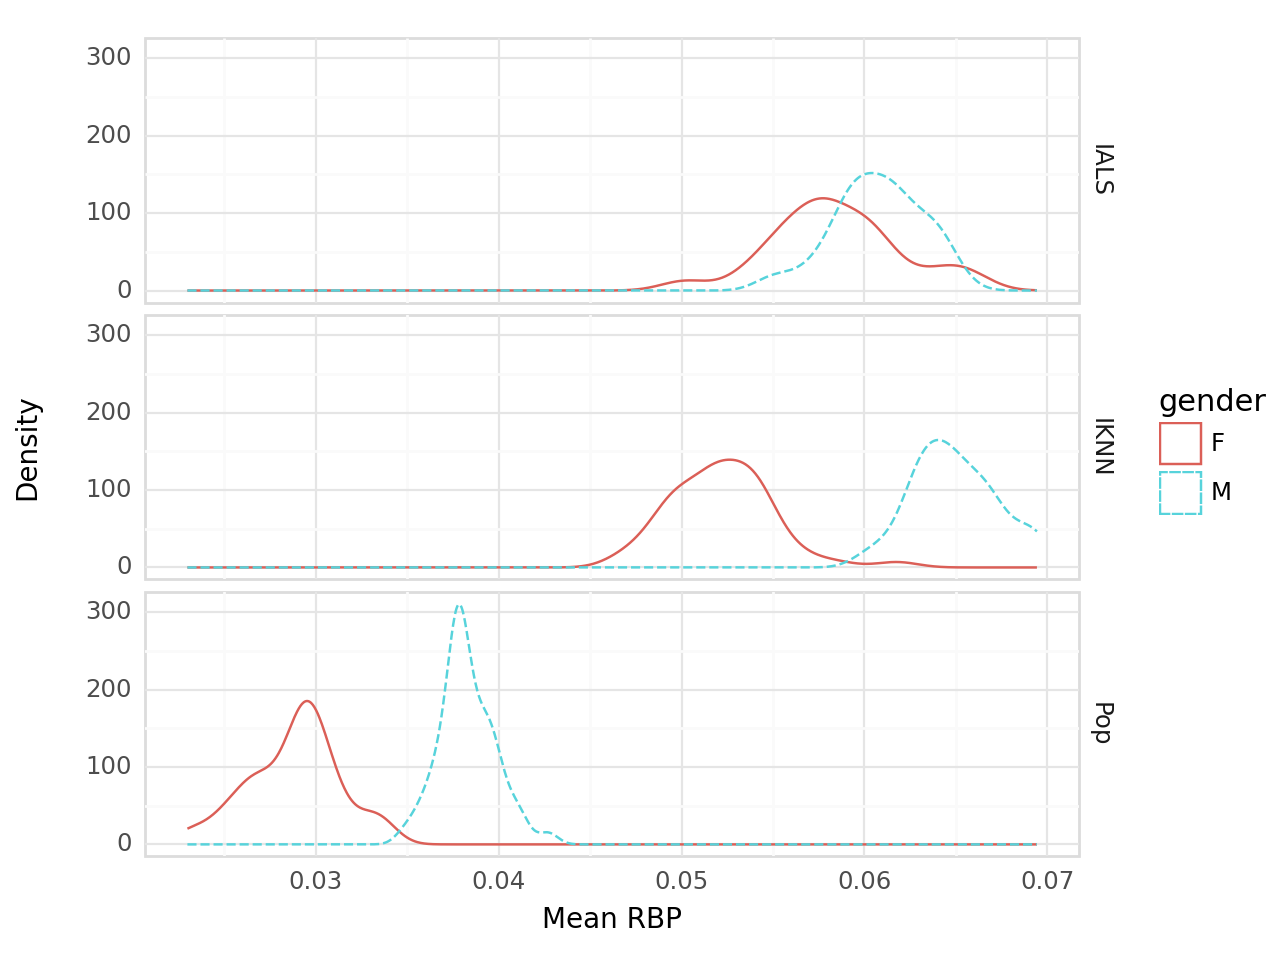

<Figure Size: (640 x 480)>

In [20]:
make_plot(
    ag_mean,
    pn.aes(x='mean', color='gender', linetype='gender'),
    pn.stat_density(),
    pn.facet_grid('algo ~'),
    pn.xlab('Mean RBP'),
    pn.ylab('Density'),
    width=4.5,
    height=3.5,
    file='repetition-gender-dist.png',
)